# **2 Naive Bayes Classifier**

This part of the homework is done by Cem Daloglu only.

In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets 
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from IPython.display import Image

In [70]:
digits = load_digits ()
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

In [71]:
from sklearn import model_selection
X_all = data
y_all = target
X_train , X_test , y_train , y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)

In [72]:
X_test_3 = X_test[np.argwhere(y_test == 3)]
X_train_3 = X_train[np.argwhere(y_train == 3)]
X_train_3.reshape((len(X_train_3), 64))
y_train_3 = y_train[np.argwhere(y_train == 3)]
y_test_3 = y_test[np.argwhere(y_test == 3)]

X_test_9 = X_test[np.argwhere(y_test == 9)]
X_train_9 = X_train[np.argwhere(y_train == 9)]
X_train_9.reshape((len(X_train_9), 64))
y_train_9 = y_train[np.argwhere(y_train == 9)]
y_test_9 = y_test[np.argwhere(y_test == 9)]

X_train_3_9 = np.append(X_train_3, X_train_9).reshape((len(X_train_3)+len(X_train_9), 64))
y_train_3_9 = np.append(y_train_3, y_train_9).astype(int)

X_test_3_9 = np.append(X_test_3, X_test_9).reshape((len(X_test_3)+len(X_test_9), 64))
y_test_3_9 = np.append(y_test_3, y_test_9).astype(int)

In [73]:
def reduce_dim(x):
  # average features
  first_row = np.zeros((7,8))
  first_row = np.insert(first_row, 0, 1, axis=0)
  fourth_column = np.zeros((8,7))
  fourth_column = np.insert(fourth_column, 4, 1, axis=1)

  first_row = np.reshape(first_row, (64, 1))
  fourth_column = np.reshape(fourth_column, (64, 1))

  output = x @ first_row
  output = np.concatenate((output, x @ fourth_column), axis=1)
  return output

In [74]:
reduced_x_test = reduce_dim(X_test_3_9)
reduced_x_train_3_9 = reduce_dim(X_train_3_9)

In [75]:
def fit_naive_bayes(features, labels, bincount=0):
  if(bincount == 0):
    reduced_x_train_3 = np.reshape(features[np.argwhere(labels == 3)], (-1, 2))
    reduced_x_train_9 = np.reshape(features[np.argwhere(labels == 9)], (-1, 2))
    reduced_arr = [reduced_x_train_3[:, 0], reduced_x_train_3[:, 1], reduced_x_train_9[:, 0], reduced_x_train_9[:, 1]]
    reduced_arr = np.reshape(reduced_arr, (2, 2))

    bin_edges1_3 = np.histogram_bin_edges(reduced_x_train_3[:, 0], bins='fd')
    bin_edges2_3 = np.histogram_bin_edges(reduced_x_train_3[:, 1], bins='fd')
    bin_edges1_9 = np.histogram_bin_edges(reduced_x_train_9[:, 0], bins='fd')
    bin_edges2_9 = np.histogram_bin_edges(reduced_x_train_9[:, 1], bins='fd')

    bin_count1_3 = len(bin_edges1_3) - 1
    bin_count2_3 = len(bin_edges2_3) - 1
    bin_count1_9 = len(bin_edges1_9) - 1
    bin_count2_9 = len(bin_edges2_9) - 1

    L = np.max([bin_count1_3, bin_count2_3, bin_count1_9, bin_count2_9])
    bin_count_arr = [bin_count1_3, bin_count2_3, bin_count1_9, bin_count2_9]
    edge_arr = [bin_edges1_3, bin_edges2_3, bin_edges1_9, bin_edges2_9]
    bin_width_arr = [bin_edges1_3[1] - bin_edges1_3[0], bin_edges2_3[1] - bin_edges2_3[0], bin_edges1_9[1] - bin_edges1_9[0], bin_edges2_9[1] - bin_edges2_9[0]]

    for i in range(len(edge_arr)):
      max_ind = np.argmax(bin_count_arr)
      if(i != max_ind):
        edge_arr[i] = np.pad(edge_arr[i], (0, L - bin_count_arr[i]))

    binning = np.zeros((2, 2, 2))
    edge_arr = np.reshape(edge_arr, (2, 2, -1))
    bin_width_arr = np.reshape(bin_width_arr, (2, 2))
    for x in range(len(binning)):
      for y in range(len(binning[0])):
        binning[x][y][0] = edge_arr[x][y][0]
        binning[x][y][1] = bin_width_arr[x][y]
    
    histograms = np.zeros((2, 2, L))
    bin_count_arr = np.reshape(bin_count_arr, (2, 2))
    for k in range(2):
      for j in range(2):
        for y in range(bin_count_arr[k][j]):
          count = 0
          for x in range(len(reduced_arr[k, j])):
            if(edge_arr[k][j][y] < reduced_arr[k, j][x] <= edge_arr[k][j][y+1]):
              count += 1
          histograms[k][j][y] = count
    histograms = histograms / len(labels)
  else:
    feat_no = len(features[0])
    reduced_x_train_3 = np.reshape(features[np.argwhere(labels == 3)], (-1, feat_no))
    reduced_x_train_9 = np.reshape(features[np.argwhere(labels == 9)], (-1, feat_no))

    edge_arr = np.empty((2, feat_no, bincount + 1))
    bin_width_arr = np.empty((2, feat_no))
    reduced_arr = []
    reduced_arr1 = []
    for i in range(feat_no):
      hist3, bin_edges3 = np.histogram(reduced_x_train_3[:, i], bins=bincount)
      hist9, bin_edges9 = np.histogram(reduced_x_train_9[:, i], bins=bincount)
      edge_arr[0, i] = bin_edges3
      edge_arr[1, i] = bin_edges9
      bin_width_arr[0, i] = bin_edges3[1] - bin_edges3[0]
      bin_width_arr[1, i] = bin_edges9[1] - bin_edges9[0]
      reduced_arr.append([reduced_x_train_3[:, i]])
      reduced_arr1.append([reduced_x_train_9[:, i]])
    for i in range(feat_no):
      reduced_arr.append(reduced_arr1[i])
    reduced_arr = np.reshape(np.array(reduced_arr), (2, feat_no))    
  
    L = bincount
    binning = np.zeros((2, feat_no, 2))

    for x in range(len(binning)):
      for y in range(len(binning[0])):
        binning[x][y][0] = edge_arr[x][y][0]
        binning[x][y][1] = bin_width_arr[x][y]
    
    histograms = np.zeros((2, feat_no, L))
    for k in range(2):
      for j in range(feat_no):
        for y in range(bincount):
          count = 0
          for x in range(len(reduced_arr[k, j])):
            if(edge_arr[k][j][y] < reduced_arr[k, j][x] <= edge_arr[k][j][y+1]):
              count += 1
          histograms[k][j][y] = count
    histograms = histograms / len(labels)
        
  return histograms, binning

In [76]:
def predicted_naive_bayes(test_features, histograms, binning):
  predicted_labels = np.zeros(len(test_features))
  for i in range(len(test_features)):
    l_kj = np.zeros((2, 2))
    for k in range(2):
      for j in range(2):
        if(int(np.floor((test_features[i, j] - binning[k][j][0]) / binning[k][j][1])) >= len(histograms[0][0]) or int(np.floor((test_features[i, j] - binning[k][j][0]) / binning[k][j][1]) < 0)):
          l_kj[k][j] = 1 / len(histograms[0][0])
        else:
          l_kj[k][j] = histograms[k, j][int(np.floor((test_features[i, j] - binning[k][j][0]) / binning[k][j][1]))]
    sum1 = np.sum(l_kj[0])
    sum2 = np.sum(l_kj[1])
    if(sum1 > sum2):
      predicted_labels[i] = 3
    else:
      predicted_labels[i] = 9
  return predicted_labels

In [77]:
from sklearn.metrics import confusion_matrix
histograms, binning = fit_naive_bayes(reduced_x_train_3_9, y_train_3_9, bincount=0)
pred = predicted_naive_bayes(reduced_x_test, histograms, binning)
print(np.sum(pred == y_test_3_9) / len(y_test_3_9))
print('confusion matrix')
print(confusion_matrix(y_test_3_9, pred))

histograms, binning = fit_naive_bayes(X_train_3_9, y_train_3_9, bincount=8)
pred = predicted_naive_bayes(X_test_3_9, histograms, binning)
print(np.sum(pred == y_test_3_9) / len(y_test_3_9))
print('confusion matrix')
print(confusion_matrix(y_test_3_9, pred))

0.7013888888888888
confusion matrix
[[47 23]
 [20 54]]
0.5694444444444444
confusion matrix
[[18 52]
 [10 64]]


<ipython-input-78-a699cf70c911>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_2, y_2, z_2, alpha=0.05, cmap="bwr_r")


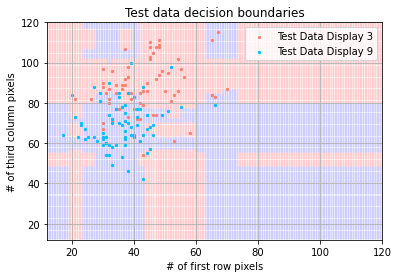

In [78]:
axis_dim = 200

x_1 = np.linspace(np.min(reduced_x_test)-5, np.max(reduced_x_test) + 5, axis_dim)
y_1 = np.linspace(np.min(reduced_x_test)-5, np.max(reduced_x_test) + 5, axis_dim)
x_2, y_2 = np.meshgrid(x_1, y_1)

x_2_new = np.reshape(x_2, (axis_dim*axis_dim,1))
y_2_new = np.reshape(y_2, (axis_dim*axis_dim,1))
tmp = np.concatenate((x_2_new, y_2_new), axis=1)

histograms, binning = fit_naive_bayes(reduced_x_train_3_9, y_train_3_9, bincount=0)
pred_red = predicted_naive_bayes(tmp, histograms, binning)

z_2 = np.reshape(pred_red, (axis_dim, axis_dim))

plt.figure()
plt.pcolormesh(x_2, y_2, z_2, alpha=0.05, cmap="bwr_r")
plt.grid(True)

plt.scatter(reduced_x_test[np.where(y_test_3_9==3),0],reduced_x_test[np.where(y_test_3_9==3),1], s=5, color="salmon", label="Test Data Display 3")
plt.scatter(reduced_x_test[np.where(y_test_3_9==9),0],reduced_x_test[np.where(y_test_3_9==9),1], s=5, color="deepskyblue", label="Test Data Display 9")

plt.legend()
plt.xlabel("# of first row pixels")
plt.ylabel("# of third column pixels")
plt.title("Test data decision boundaries")
plt.show()